# The HRRR Zarr Archive Explained

In this document, I'll walk you through the HRRR Zarr archive, its data model, and how to read it, without assuming much prior knowledge. But first, let me get some bullet points for the experts reading this.

## Quick Notes for Experts
(Just scroll down if this is all gobbledly-gook to you!)

 * The Zarr archive was generated from the original GRIB2 files using [iris-grib](https://iris-grib.readthedocs.io/en/stable/) and [xarray](http://xarray.pydata.org/en/stable/). As a result, you can get the expected metadata by loading with xarray. However, there's a deeply-nested subgroup structure that requires [xarray.open_mfdataset](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html) to load, example code is given below.
 * If the data model seems a little strange, it's because it was developed with an atypical access pattern in mind: Reading individual chunks of the zarr array instead of the whole thing. The chunking is done in a consistent manner along the geospatial grid, so investigators interested in a single gridpoint or small region can get all the data they need from many model runs by accessing a specific chunk. There aren't any nice high-level APIs for accessing the data this way, but an example is given below.
 * We have a [list of the available variables](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html) which should suffice to help you locate them in the [S3 data](https://hrrrzarr.s3.amazonaws.com/index.html).

## Major differences between the HRRR Zarr and GRIB2 data models

The motivation behind the Zarr project was to provide quick access to subsets of the data stored in the large GRIB2 files. A few major differences deserve to be highlighted:

* The Zarr archive prioritizes access of a single variable. Each variable has its own Zarr array in a different directory. To the user, the variables they're not using might as well not exist.
* In the grib archive, data for each forecast hour is in a different file. In Zarr, data from all forecast hours for a given model run are aggregated into a time series at each grid point. (However, different model runs are not aggregated for either archive, meaning there is no time aggregation for analysis data).
* The Zarr archive supports access to pre-defined chunks of the original grid, so users can download a specific region of data instead of data for the entire CONUS. This is kind of clunky, though.

Note that none of these differences are inherent to the zarr format. Another team could create a HRRR zarr archive with completely different features.

## S3 Archive Layout

You can browse the data [here](https://hrrrzarr.s3.amazonaws.com/index.html). Let's look at it more closely. (Or you can scroll down and start copy-pasting code, I'm not your mom.)

### Top Level

You'll see three directories:
* grid
* sfc
* prs

The first, "grid", is not part of the HRRR data per se. It contains a convenient file for looking up the index values of the data by latitude and longitude. You probably won't have to use it.

"sfc" and "prs" are the surface- and pressure-level data from the HRRR. While "prs" may be used for some specialized investigations, most users are looking for data under "sfc" (which does include some variables at different pressure levels despite the name!).

### By Date

Once you click into "sfc" or "prs", you'll see a bunch of directories in %Y%m%d (or YYYYMMDD) format. Since the HRRR runs every hour, these are convenient aggregations by day (in UTC).

Step in again and the new format for directories containing model runs by hour is %Y%m%d_%Hz_\[fcst|anl\].zarr

The "fcst" and "anl" suffixes represent the forecast and analysis data from the HRRR. Many studies use the analysis data as a source of historical weather data for the CONUS, and the zarr arrays here are 2-dimensional, not requiring a time dimension given that time is encoded in the directory structure. 

The forecast arrays, however, are three-dimensional: The directory structure represents when the model was initialized, but the data itself has a further time dimension for every forecast hour. This is one advantage of the zarr archive over the grib archive, since the grib archive has a separate file for every forecast hour instead of aggregating the forecasts into time series.

### By Variable

Each variable is specified by a level (e.g. "1000mb") and a short name (e.g. "TMP"). After selecting the hour of the model run, you get a listing of levels, and inside of those is a listing of variables by short name. You can see the available variables [here](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html).

The directories start to correspond to zarr "groups" on the model run (hour) level, so you'll start seeing .zgroup and .zmetadata files. After selecting a level and short name, you'll see a variety of subdirectories with zarr arrays corresponding to the spatiotemporal coordinates of the data, such as: "projection_x_coordinate", "time", and "height". You may see similar ways of handling coordinates in other zarr data since these are [handled]((http://xarray.pydata.org/en/stable/internals/zarr-encoding-spec.html)) by the xarray library which was used to write the zarr data in this case.

Because the variable name is actually being represented as "\<level\>/\<short name\>", the main data array is in a somewhat confusingly-nested structure, so you have to click on "\<level\>" and then "\<short name\>" again to get to the final data directory. It'll have a .zarray metadata file as well chunks represented regions on the grid with the format number.number

### By Chunk

While lookup-by-chunk isn't a typical access pattern for the zarr data format, the HRRR Zarr archive supports it. Every array is chunked in a consistent manner with respect to the geospatial grid, as shown in this image. The ids on the image are the same as the chunk ids in the object names on S3. There'll be code below that shows how to get the correct chunk based on longitude and latitude.

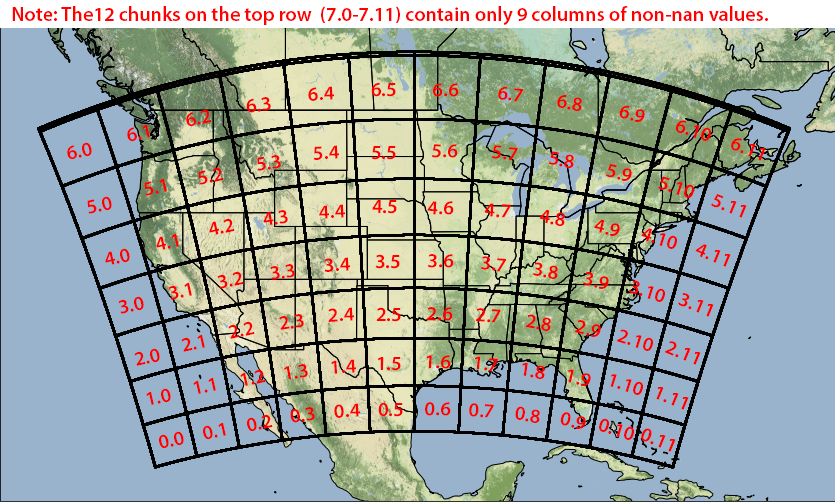

## Access and Use Example - Analysis Data

In this example, we load and graph a snapshot of temperature data using xarray.

### Creating the lookup URL(s)

We need to pass xarray 2 urls to load the data properly:
* The url of the zarr group containing the coordinates
* The url of the zarr subgroup containing the data

Note that we would only have to pass the group url if the variable name didn't have a slash in it (level / parameter short name). The slash is being interpreted as an extra level of nesting which prevents the group from loading properly.

In [2]:
import datetime

date = datetime.datetime(2021, month=1, day=1, hour=19)

def get_variable(level, short_name):
    return level + "/" + short_name

level = "1000mb"
variable = get_variable(level, "TMP")

def get_group_url(date, variable, forecast=False):
    date_string = date.strftime("%Y%m%d")
    time_string = date_string + date.strftime("_%Hz")
    suffix = "fcst" if forecast else "anl"
    return f"s3://hrrrzarr/sfc/{date_string}/{time_string}_{suffix}.zarr/{variable}"

def get_variable_subgroup_url(level, date, variable, forecast=False):
    return get_group_url(date, variable, forecast) + "/" + level

group_url = get_group_url(date, variable)
subgroup_url = get_variable_subgroup_url(level, date, variable)

print(group_url, subgroup_url)

s3://hrrrzarr/sfc/20210101/20210101_19z_anl.zarr/1000mb/TMP s3://hrrrzarr/sfc/20210101/20210101_19z_anl.zarr/1000mb/TMP/1000mb


### Loading with xarray

In [39]:
import xarray as xr
import s3fs

fs = s3fs.S3FileSystem(anon=True)
ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in [group_url, subgroup_url]], engine='zarr')
ds

<xarray.Dataset>
Dimensions:                  (projection_x_coordinate: 1799, projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    pressure                 float64 ...
    time                     datetime64[ns] ...

### Projection information

Notice that the coordinates for the data are projection_x_coordinate and projection_y_coordinate, not latitude and longitude. What is that projection? Unfortunately, xarray [doesn't support projections](https://github.com/pydata/xarray/issues/2288) so we have to use a [metpy extension](https://unidata.github.io/MetPy/dev/tutorials/xarray_tutorial.html) to do so.

In [37]:
# I was getting a SQL error from inconsistent pyproj setup

import pyproj
print(pyproj.datadir.get_data_dir())
pyproj.datadir.set_data_dir("/Users/adairkovac/.conda/envs/TetheredBalloon-7710/share/proj")
print(pyproj.datadir.get_data_dir())

/opt/anaconda3/share/proj
/Users/adairkovac/.conda/envs/TetheredBalloon-7710/share/proj


In [38]:
import metpy

ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
ds = ds.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", longitude_of_central_meridian=-97.5,
                             latitude_of_projection_origin=38.5,
                             standard_parallel=38.5)
ds = ds.metpy.assign_latitude_longitude()
ds

/Users/adairkovac/.conda/envs/TetheredBalloon-7710/lib/python3.8/site-packages/metpy/xarray.py:893: UserWarning: No latitude and longitude assigned since horizontal coordinates were not found
  warnings.warn('No latitude and longitude assigned since horizontal coordinates '


<xarray.Dataset>
Dimensions:    (x: 1799, y: 1059)
Coordinates:
    metpy_crs  object Projection: lambert_conformal_conic
Dimensions without coordinates: x, y
Data variables:
    TMP        (y, x) float16 ...

Side note: If for some reason the conversion isn't working above, you can also create the grid manually:

In [225]:
import numpy as np

standard_projection = ccrs.PlateCarree()
projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])
grid_y, grid_x = np.meshgrid(ds.projection_y_coordinate.values, ds.projection_x_coordinate.values)
grid_longitude, grid_latitude, _ = standard_projection.transform_points(projection, grid_x, grid_y).T
# ds["longitude"] = lon_arr =  xr.DataArray(grid_longitude, dims=["projection_y_coordinate", "projection_x_coordinate"])
# ds["latitude"] = lat_arr = xr.DataArray(grid_latitude, dims=["projection_y_coordinate", "projection_x_coordinate"])

We can use this to map the data:

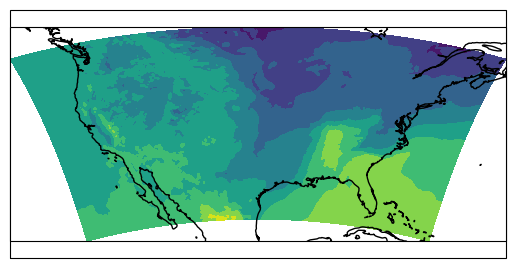

In [265]:
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(ds.longitude, ds.latitude, ds.TMP)
ax.coastlines()

plt.show()

Now let's use our new lat/lon coordinates to filter to an area around Florida.

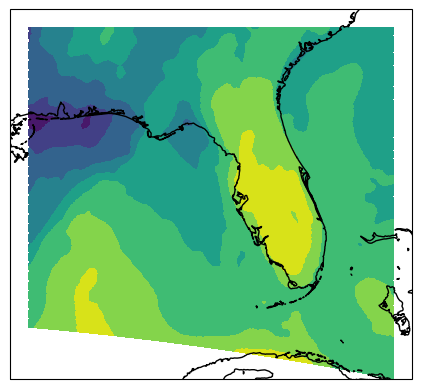

In [267]:
ds_filtered = ds.where((ds.latitude < 33) & (ds.latitude > 21) & (ds.longitude < -78) & (ds.longitude > -89), drop=True)

plt.close()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(ds_filtered.longitude, ds_filtered.latitude, ds_filtered.TMP)
ax.coastlines()

plt.show()

Note that xarray also offers a quick-plotting function if you just want a quick view of your data.

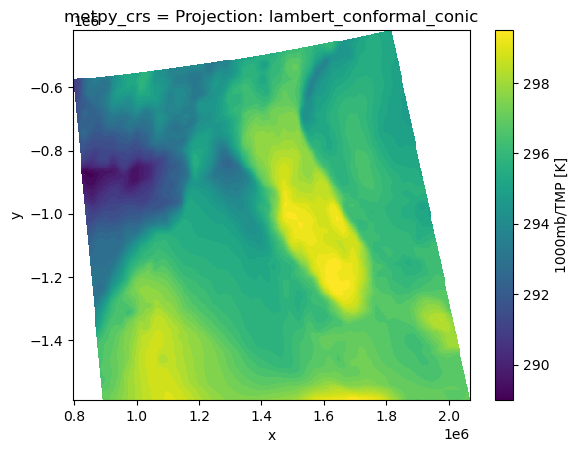

In [268]:
ds_filtered.TMP.plot()
plt.show()

### Accessing data from different times

Unfortunately, the following doesn't work because the "time" coordinate .zarray doesn't have the \_ARRAY\_DIMENSIONS attribute defined.

In [207]:
urls = [group_url, subgroup_url]
for i in range(1, 3):
    new_time = date + datetime.timedelta(days=i)
    new_group_url = get_group_url(new_time, variable)
    new_subgroup_url = get_variable_subgroup_url(level, new_time, variable)
    urls = urls + [new_group_url, new_subgroup_url]

multiday_ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
multiday_ds

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

As a result, we have to merge the data ourselves. This does provide the advantage of letting us filter as soon as each dataset is downloaded!

In [271]:
def filter(ds):
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", longitude_of_central_meridian=-97.5,
                             latitude_of_projection_origin=38.5,
                             standard_parallel=38.5)
    ds = ds.metpy.assign_latitude_longitude()
    return ds.where((ds.latitude < 33) & (ds.latitude > 21) & (ds.longitude < -78) & (ds.longitude > -89), drop=True)

combined_ds = None
for i in range(0, len(urls), 2):
    urls_for_time = urls[i:i+2]
    partial_ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls_for_time], engine='zarr')
    partial_ds = partial_ds.set_coords("time")
    partial_ds = filter(partial_ds)
    if not combined_ds:
        combined_ds = partial_ds
    else:
        combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")

print(combined_ds)

<xarray.Dataset>
Dimensions:                  (time: 3, x: 424, y: 390)
Coordinates:
  * x                        (x) float64 7.975e+05 8.005e+05 ... 2.066e+06
  * y                        (y) float64 -1.587e+06 -1.584e+06 ... -4.203e+05
  * time                     (time) datetime64[ns] 2021-01-01T19:00:00 ... 20...
    metpy_crs                object Projection: lambert_conformal_conic
    latitude                 (y, x) float64 24.03 24.03 24.03 ... 32.48 32.48
    longitude                (y, x) float64 -89.88 -89.86 ... -75.45 -75.42
Data variables:
    TMP                      (time, y, x) float16 dask.array<chunksize=(1, 150, 35), meta=np.ndarray>
    forecast_period          (time, y, x) timedelta64[ns] NaT NaT ... NaT NaT
    forecast_reference_time  (time, y, x) datetime64[ns] NaT NaT NaT ... NaT NaT
    height                   (time, y, x) float64 nan nan nan ... nan nan nan
    pressure                 (time, y, x) float64 nan nan nan ... nan nan nan


Let's now use this data: We'll calculate the average over time, then map each time's difference from the average.

/Users/adairkovac/.conda/envs/TetheredBalloon-7710/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


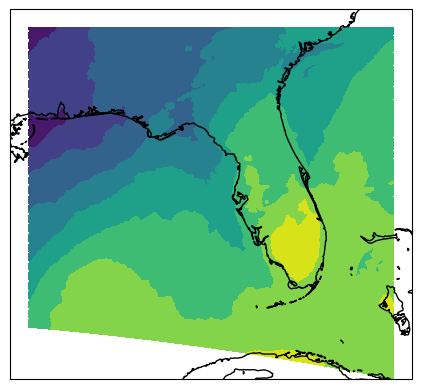

In [272]:
avg_temp = combined_ds.mean(dim="time")

plt.close()

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(avg_temp.longitude, avg_temp.latitude, avg_temp.TMP)
ax.coastlines()

plt.show()

/Users/adairkovac/.conda/envs/TetheredBalloon-7710/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


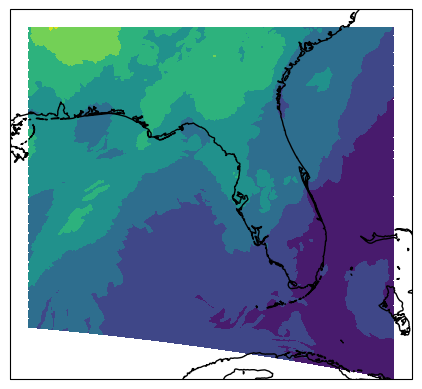

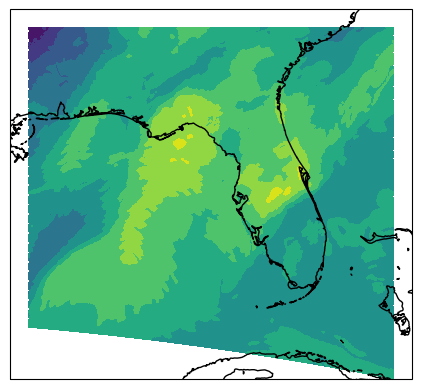

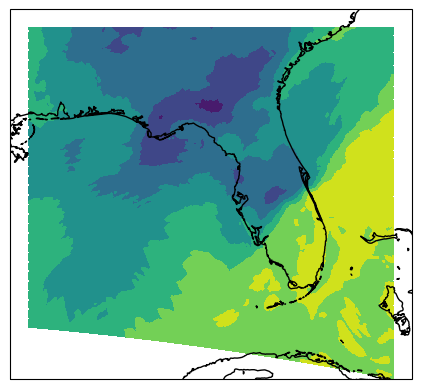

In [273]:
residuals = combined_ds - avg_temp
for time in residuals.time:
    plt.close()
    to_plot = residuals.TMP.sel(time=time)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.contourf(to_plot.longitude, to_plot.latitude, to_plot)
    ax.coastlines()
    plt.show()

## Access and Use Example - Forecast Data

### Time series

## Access By Chunk